In [1]:
%matplotlib inline

In [8]:
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import h5py, pylab, struct
import matplotlib.cm as cm
import conversions as co
import pandas as pd

#### TODO:
* PLOTS

#### Aspirations:
* Wrap the hdf5 reader such that it can read in chunks at a time

#### Notes:
* snap hdf5 structure: f has keys 'Header', 'PartType1,2,3'
* PartTypes have no attrs, keys = "Coordinates", "ParticleIDs", "Velocities" with no attrs
    * Coords and Vels are ndarrays len == 3
    * PT1=DM (20mil x 3), PT2=disk (8mil x 3), PT3=bulge (2.8mil x 3)
* header has attributes with value == 0: 
    * BoxSize, OmegaLambda, Redshift
    * Flag_[Cooling, DoublePrecision, Feedback, IC_Info, Metals, Sfr, StellarAge]
* nonzero attrs: 
    * HubbleParam, Omega0 == 1, Time (in years / 10^9 (????))
    * NumPart_ThisFile == NumPart_Total (array len 6), MassTable (array len 6)

In [149]:
def read_hdf5(path, p_type=1):
    """types: 1=DM, 2=disk, 3=bulge"""
    groups = ["Header", "PartType1", "PartType2", "PartType3"]
    head = {}
    
    f = h5py.File(path, "r")
    h = f["Header"]
    keys = list(h.attrs)
    for key in keys:
        head[key] = h.attrs[key]
    parts = f[groups[p_type]]
    columns = ["x","y","z", "vx", "vy", "vz"]
    df = pd.DataFrame(np.concatenate((parts["Coordinates"], parts["Velocities"]), axis=1),
                     columns=columns, index=parts["ParticleIDs"][:])
    f.close()
    
    return head, df

In [157]:
path = "data/snap_582.hdf5"
h, df = read_hdf5(path, p_type=3) #testing with fewer particles
df

,x,y,z,vx,vy,vz
28639916,-41.364201,-0.868397,-24.016346,94.006210,-4.976634,61.801258
29546391,-40.073154,0.106762,-23.555355,196.836517,-1.480761,-90.483757
29505943,-42.349831,-0.618606,-21.989767,-213.720779,-94.062553,130.978668
30294667,-46.743774,-2.320340,-20.091316,-145.880554,7.030462,65.931801
30159727,-43.725334,-1.985742,-22.726196,-159.082825,22.662899,-105.977768
...,...,...,...,...,...,...
29222458,-13.814735,-14.249855,77.030037,47.659611,-12.432306,-85.064423
29589556,-13.454148,-42.402237,86.330467,-25.662546,-49.453171,35.612667
29151553,-4.812218,-33.069962,104.416122,-104.050850,37.620075,105.977150
29900917,-5.719983,-28.821281,101.478615,-39.821232,-85.115784,3.542554


In [230]:
path = "data/snap_582.hdf5"
head, df = read_hdf5(path, p_type=3) #testing with fewer particles
df["x"] = df["x"] - df["x"].median()
df["y"] = df["y"] - df["y"].median()
#hist ,xbin, ybin = np.histogram2d(df["x"], df["y"], normed=True, bins=[360,360])
#plt.hist2d(df["x"], df["y"], density=True, bins=[360,360])

,x,y,z,vx,vy,vz
count,2.800000e+06,2.800000e+06,2.800000e+06,2.800000e+06,2.800000e+06,2.800000e+06
mean,-1.941427e-02,4.710048e-02,3.223124e+00,1.359136e+00,-4.453424e+00,2.152786e+00
std,1.979492e+01,1.968668e+01,1.958961e+01,1.110128e+02,1.175841e+02,1.200170e+02
min,-1.631899e+03,-1.568078e+03,-1.537456e+03,-6.292950e+02,-6.345322e+02,-6.274742e+02
25%,-3.972310e-01,-3.309103e-01,2.936787e+00,-7.186260e+01,-8.197449e+01,-7.816029e+01
50%,0.000000e+00,0.000000e+00,3.243209e+00,1.324185e+00,-4.448832e+00,2.176461e+00
75%,3.944000e-01,3.308567e-01,3.547980e+00,7.466910e+01,7.310990e+01,8.253123e+01
max,1.454176e+03,1.588692e+03,1.553957e+03,5.946782e+02,6.198492e+02,5.915703e+02


In [244]:
df["theta"] = np.arctan2(df["x"],df["y"])
df["r"] = np.sqrt(df["x"] ** 2 + df["y"] ** 2)
df["r"].describe()

count    2.800000e+06
mean     3.763265e+00
std      2.766306e+01
min      1.496943e-04
25%      2.976664e-01
50%      6.284443e-01
75%      1.682391e+00
max      1.642760e+03
Name: r, dtype: float64

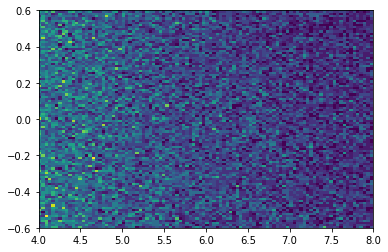

In [250]:
h, redg, thedg, img = plt.hist2d(df["r"], df["theta"], bins=[100,100], range=[[4, 8],[-0.6,0.6]])

In [234]:
head["HubbleParam"]

0.678

Rs =  1.8726196215911357 2.8770973183672403e-07


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10


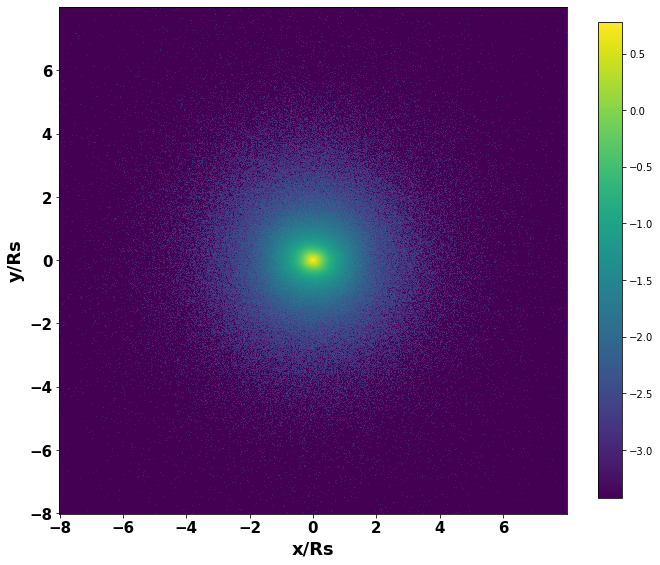

In [189]:
path = "data/snap_582.hdf5"
head, df = read_hdf5(path, p_type=3) #testing with fewer particles
df["x"] = df["x"] - df["x"].median()
df["y"] = df["y"] - df["y"].median()
mass = head["MassTable"][3]
BINS_r, BINS_theta = 360,360
BINS=512
lengthX=15.0
lengthY=15.0
vx0=-5.0
vy0=170.0
Zmin=-4.25
Zmax=-0.27
rmin, rmax = 0., 15.
dtheta=2*np.pi/BINS_theta
dr=(rmax-rmin)/BINS_r
thetamid=(np.arange(BINS_theta)+0.5) * dtheta - np.pi   
rmid=(np.arange(BINS_r)+0.5) * dr + rmin

px,py = df["x"], df["y"]
r=np.sqrt(px**2. + py**2.) 
theta=np.arctan2(py,px)
h, x, y = np.histogram2d(r,theta,bins=[BINS_r,BINS_theta],range=[[rmin,rmax],[-np.pi,np.pi]])

#divide by area to get surface density
for i in range(0,BINS_r):
        h[i,:]/=rmid[i]*dr*dtheta

#fit the axisymmetric surface density            
meanh=np.zeros(BINS_r)
for i in range(0,BINS_r):
        meanh[i]=h[i,:].mean()
z=np.polyfit(rmid, np.log(meanh), 1)
Rs=-1/z[0]
p = np.poly1d(z)
print( "Rs = ", Rs, mass )

#calculate residuals
for i in range(0,BINS_r):
        #h[i,:]=(h[i,:] - np.exp(p(rmid[i]))) / np.exp(p(rmid[i]))
        h[i,:]=(h[i,:] - h[i,:].mean()) / (h[i,:].mean())
Z,x,y=np.histogram2d(px/Rs,py/Rs, range=[[-lengthX/Rs,lengthX/Rs],[-lengthY/Rs,lengthY/Rs]], bins=BINS, normed=True)

Z=np.log10(Z)


Zmin=Z[Z>-np.inf].min()
Zmax=Z[Z<np.inf].max()
if ((Zmax==0.0) & (Zmin==0.0)):
        Zmin=Z[Z>-np.inf].min()
        Zmax=Z.max()
else:
        Z[Z<Zmin]=Zmin
        Z[Z>Zmax]=Zmax
fig = plt.figure(1, figsize=(25.0,25.0))

#left plot
#ax = fig.add_subplot(1,2,1,title=tname+"  t="+str(round(head.time*co.UnitTime_in_Gyr*1000.0,1))+"Myr")

ax = fig.add_subplot(1,2,1) #,title=tname+"  t="+str(round(myTime*co.UnitTime_in_Gyr*1000.0,1))+"Myr")
im=ax.imshow(Z.T, vmin=Zmin, vmax=Zmax,
        origin='lower',interpolation='nearest',
        extent=[-lengthX/Rs,lengthX/Rs,-lengthY/Rs,lengthY/Rs],
        cmap=cm.get_cmap('viridis'))
ax.set_xlabel('x/Rs', fontsize=18, fontweight='bold')
ax.set_ylabel('y/Rs',fontsize=18, fontweight='bold')
plt.xticks(np.arange(-round(lengthX/Rs), round(lengthX/Rs), step=2), fontsize=15, fontweight='bold')
plt.yticks(np.arange(-round(lengthY/Rs), round(lengthY/Rs), step=2), fontsize=15, fontweight='bold')
plt.colorbar(im, shrink=0.35)        

19.794922
done


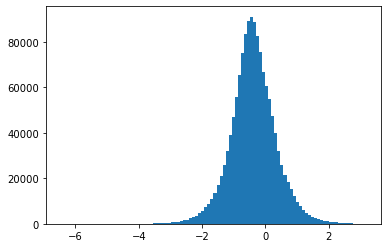

In [226]:
bins = 100
#hist, xedg, yedg, img = plt.hist2d(df["x"], df["y"], density=True, bins=[bins,bins], cmin=1)
x,y = df["x"], df["y"]
std = x.std()
high = std
low = -std
#plt.hist2d(df["x"], df["y"])
plt.hist(np.log10(x), bins=bins)

In [ ]:
img